In [1]:
'''Trains a memory network on the bAbI dataset.
References:
- Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush,
  "Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks",
  http://arxiv.org/abs/1502.05698
- Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus,
  "End-To-End Memory Networks",
  http://arxiv.org/abs/1503.08895
'''
from __future__ import print_function

from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from functools import reduce

import os
import numpy as np
import re
import tarfile
import codecs
import matplotlib.pyplot as plt
def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]


def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences
    that support the answer are kept.
    '''
    data = []
    story = []
    for ti, line in enumerate(lines):
        line = line.strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            '''if len(re.split('\?',line,1)) == 2:
                q, a = re.split('\?',line, 1)
            else:
                q, _, a = re.split('\?', line, 2)
            _, a, supporting = a.split(' ',2)'''
            q = tokenize(q)
            substory = None
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


def get_stories(f, only_supporting=False, max_length=None):
    '''Given a file name, read the file,
    retrieve the stories,
    and then convert the sentences into a single story.
    If max_length is supplied,
    any stories longer than max_length tokens will be discarded.
    '''
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    story_sentence_maxlen = max(map(len, (x for x, _, _ in data )))
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data_flatten = [(flatten(story), q, answer) for story, q, answer in data if not max_length or len(flatten(story)) < max_length]
    return data_flatten, story_sentence_maxlen, data


def vectorize_stories(data, word_idx, story_maxlen, query_maxlen, story_sentence_maxlen):
    X = []
    Xq = []
    Y = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        y = np.zeros(story_sentence_maxlen + 1)
        y[int(answer)] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return (pad_sequences(X, maxlen=story_maxlen),
            pad_sequences(Xq, maxlen=query_maxlen), np.array(Y))

Using TensorFlow backend.


## Preprocessing (DATA READOUT)

In [2]:
path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
tar = tarfile.open(path)
challenges = {
    # QA1 with 10,000 samples
    'single_supporting_fact_10k': 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt',
    # QA2 with 10,000 samples
    'two_supporting_facts_10k': 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt',
    # Squad sample for test
    'squad_sample': './data/squad/sample_{}.txt',
    # Squad
    'squad': './data/squad/{}.txt',
}
babi = False
challenge_type = 'squad' #'single_supporting_fact_10k'
challenge = challenges[challenge_type]

print('Extracting stories for the challenge:', challenge_type)
if babi:
    train_stories, _, _ = get_stories(tar.extractfile(challenge.format('train')))
    test_stories, _, _ = get_stories(tar.extractfile(challenge.format('test')))
else:
    train_stories, train_story_sentence_maxlen, train_stories_ori = get_stories(codecs.open(challenge.format('train'), "r", "utf-8"))
    test_stories, test_story_sentence_maxlen, test_stories_ori = get_stories(codecs.open(challenge.format('test'), "r", "utf-8"))

vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q)
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))
story_sentence_maxlen = max([train_story_sentence_maxlen,test_story_sentence_maxlen])
print('-')
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Story sentence max number:', story_sentence_maxlen, 'sentences')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-')
print('Here\'s what a "story" tuple looks like (input, query, answer):')
print(train_stories[0])
print('-')
print('Vectorizing the word sequences...')

word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories,
                                                               word_idx,
                                                               story_maxlen,
                                                               query_maxlen,
                                                               story_sentence_maxlen)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories,
                                                            word_idx,
                                                            story_maxlen,
                                                            query_maxlen,
                                                            story_sentence_maxlen)

print('-')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('-')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train shape:', queries_train.shape)
print('queries_test shape:', queries_test.shape)
print('-')
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)')
print('answers_train shape:', answers_train.shape)
print('answers_test shape:', answers_test.shape)
print('-')
print('Compiling...')

Extracting stories for the challenge: squad


C:\Users\Jaejun Yoo\Anaconda3\envs\tensorflow35\lib\re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


-
Vocab size: 102119 unique words
Story max length: 844 words
Query max length: 60 words
Story sentence max number: 29 sentences
Number of training stories: 87599
Number of test stories: 33539
-
Here's what a "story" tuple looks like (input, query, answer):
(['Architecturally', ',', 'the', 'school', 'has', 'a', 'Catholic', 'character', '.', 'Atop', 'the', 'Main', 'Building', "'", 's', 'gold', 'dome', 'is', 'a', 'golden', 'statue', 'of', 'the', 'Virgin', 'Mary', '.', 'Immediately', 'in', 'front', 'of', 'the', 'Main', 'Building', 'and', 'facing', 'it', ',', 'is', 'a', 'copper', 'statue', 'of', 'Christ', 'with', 'arms', 'upraised', 'with', 'the', 'legend', '"', 'Venite', 'Ad', 'Me', 'Omnes', '".', 'Next', 'to', 'the', 'Main', 'Building', 'is', 'the', 'Basilica', 'of', 'the', 'Sacred', 'Heart', '.', 'Immediately', 'behind', 'the', 'basilica', 'is', 'the', 'Grotto', ',', 'a', 'Marian', 'place', 'of', 'prayer', 'and', 'reflection', '.', 'It', 'is', 'a', 'replica', 'of', 'the', 'grotto', 'at'

## Model

In [3]:
# placeholders
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))

# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=64))
input_encoder_m.add(Dropout(0.3))
# output: (samples, story_maxlen, embedding_dim)

# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=query_maxlen))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

# compute a 'match' between the first input vector sequence
# and the question vector sequence
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

# the original paper uses a matrix multiplication for this reduction step.
# we choose to use a RNN instead.
answer = LSTM(32)(answer)  # (samples, 32)

# one regularization layer -- more would probably be needed.
answer = Dropout(0.3)(answer)
answer = Dense(story_sentence_maxlen+1)(answer)  # (samples, story_sentence_maxlen)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 844)           0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 60)            0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        multiple              6535616     input_1[0][0]                    
____________________________________________________________________________________________________
sequential_3 (Sequential)        (None, 60, 64)        6535616     input_2[0][0]                    
___________________________________________________________________________________________

In [4]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
# save best model
MODEL_DIR = "Z:/jj_git/elice/JARDIS/MEMN2N_BASE_MODEL/checkpoint_babi"
checkpoint = ModelCheckpoint(filepath = os.path.join(MODEL_DIR, "model-{epoch:02d}.h5"),save_best_only=True)

# train
history = model.fit([inputs_train, queries_train], answers_train,
          batch_size=32,
          epochs=100,
          verbose=2, validation_data=([inputs_test, queries_test], answers_test),callbacks = [checkpoint])

Train on 87599 samples, validate on 33539 samples
Epoch 1/100
254s - loss: 1.7575 - acc: 0.2687 - val_loss: 1.7051 - val_acc: 0.2679
Epoch 2/100
250s - loss: 1.6811 - acc: 0.2894 - val_loss: 1.7062 - val_acc: 0.2725
Epoch 3/100
249s - loss: 1.6555 - acc: 0.3067 - val_loss: 1.7149 - val_acc: 0.2692
Epoch 4/100
249s - loss: 1.6245 - acc: 0.3276 - val_loss: 1.7412 - val_acc: 0.2568
Epoch 5/100
248s - loss: 1.5838 - acc: 0.3535 - val_loss: 1.7726 - val_acc: 0.2503
Epoch 6/100
250s - loss: 1.5484 - acc: 0.3701 - val_loss: 1.8050 - val_acc: 0.2479
Epoch 7/100
248s - loss: 1.5158 - acc: 0.3884 - val_loss: 1.8466 - val_acc: 0.2492
Epoch 8/100
248s - loss: 1.4860 - acc: 0.4077 - val_loss: 1.8662 - val_acc: 0.2369
Epoch 9/100
248s - loss: 1.4584 - acc: 0.4237 - val_loss: 1.9229 - val_acc: 0.2320
Epoch 10/100
248s - loss: 1.4290 - acc: 0.4391 - val_loss: 1.9359 - val_acc: 0.2333
Epoch 11/100
248s - loss: 1.4041 - acc: 0.4564 - val_loss: 1.9994 - val_acc: 0.2166
Epoch 12/100
247s - loss: 1.3771 - 

In [5]:
score = model.evaluate([inputs_test, queries_test], answers_test, batch_size=32, verbose = 1)
print(model.metrics_names)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])


33539/33539 [==============================] - 19s    
['loss', 'acc']
Test loss:  2.78130217231
Test accuracy:  0.206744387131


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


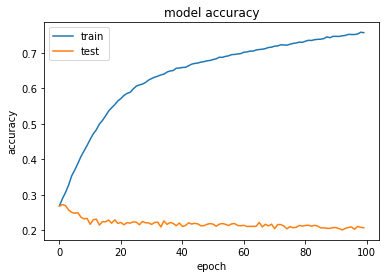

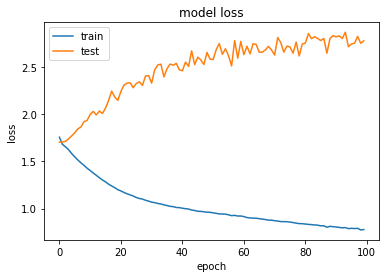

In [6]:
pred = model.predict([inputs_test, queries_test])
pred_train = model.predict([inputs_train, queries_train])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'],loc = 'upper left')
plt.show()

In [7]:
print(pred_train.shape)
print(inputs_train.shape)
print(queries_train.shape)
print(answers_train.shape)
print(train_stories[0])

(87599, 30)
(87599, 844)
(87599, 60)
(87599, 30)
(['Architecturally', ',', 'the', 'school', 'has', 'a', 'Catholic', 'character', '.', 'Atop', 'the', 'Main', 'Building', "'", 's', 'gold', 'dome', 'is', 'a', 'golden', 'statue', 'of', 'the', 'Virgin', 'Mary', '.', 'Immediately', 'in', 'front', 'of', 'the', 'Main', 'Building', 'and', 'facing', 'it', ',', 'is', 'a', 'copper', 'statue', 'of', 'Christ', 'with', 'arms', 'upraised', 'with', 'the', 'legend', '"', 'Venite', 'Ad', 'Me', 'Omnes', '".', 'Next', 'to', 'the', 'Main', 'Building', 'is', 'the', 'Basilica', 'of', 'the', 'Sacred', 'Heart', '.', 'Immediately', 'behind', 'the', 'basilica', 'is', 'the', 'Grotto', ',', 'a', 'Marian', 'place', 'of', 'prayer', 'and', 'reflection', '.', 'It', 'is', 'a', 'replica', 'of', 'the', 'grotto', 'at', 'Lourdes', ',', 'France', 'where', 'the', 'Virgin', 'Mary', 'reputedly', 'appeared', 'to', 'Saint', 'Bernadette', 'Soubirous', 'in', '1858', '.', 'At', 'the', 'end', 'of', 'the', 'main', 'drive', '(', 'and',

In [8]:
# [inputs_train, queries_train], answers_train
idx2word = dict(zip(word_idx.values(), word_idx.keys()))
index = 0

In [9]:
#depad_data(train_stories, train_questions)
question = queries_train[index]
sentence_index = int(train_stories_ori[index][2])
story_index = inputs_train[index]
print(sentence_index)

6


In [10]:
train_stories, train_story_sentence_maxlen, train_stories_ori = get_stories(codecs.open(challenge.format('train'), "r", "utf-8"))
test_stories, test_story_sentence_maxlen, test_stories_ori = get_stories(codecs.open(challenge.format('test'), "r", "utf-8"))


C:\Users\Jaejun Yoo\Anaconda3\envs\tensorflow35\lib\re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [11]:
print(train_stories_ori[index][0][6])

['At', 'the', 'end', 'of', 'the', 'main', 'drive', '(', 'and', 'in', 'a', 'direct', 'line', 'that', 'connects', 'through', '3', 'statues', 'and', 'the', 'Gold', 'Dome', '),', 'is', 'a', 'simple', ',', 'modern', 'stone', 'statue', 'of', 'Mary', '.']


In [12]:
story = train_stories[index][0]
question = train_stories[index][1]
answer = train_stories_ori[index][0][sentence_index]
prediction = train_stories_ori[index][0][np.argmax(pred_train[index])-1]
print('Story:')
print(' '.join(word for word in story))
print('\nQuestion:')
print(' '.join(word for word in question))
print('\nPrediction (sentence):')
print(' '.join(word for word in prediction))
print('\nCorrect:')
print(np.argmax(pred_train[index]) == sentence_index)

Story:
Architecturally , the school has a Catholic character . Atop the Main Building ' s gold dome is a golden statue of the Virgin Mary . Immediately in front of the Main Building and facing it , is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart . Immediately behind the basilica is the Grotto , a Marian place of prayer and reflection . It is a replica of the grotto at Lourdes , France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858 . At the end of the main drive ( and in a direct line that connects through 3 statues and the Gold Dome ), is a simple , modern stone statue of Mary .

Question:
To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France ?

Prediction (sentence):
It is a replica of the grotto at Lourdes , France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858 .

Correct:
True
